# Neural Network

## I. Import and Load Data

Training Data was pulled from two sources. 

Solar Irradience data was pulled from the [National Solar Radiation Database](https://nsrdb.nrel.gov/). Pointwise GHI, DHI, and DNI data is returned hourly for an entire calendar year. All irradience values are recorded in w/m^2. Location is for a latitude longitude coordinate pair. Coordinates were chosen based on the locations of [U.S. Climate Reference Network (USCRN)](https://www.ncdc.noaa.gov/crn/) monitoring stations. This is because the USCRN has real time measurements of GHI, which can be used to make real-time predictions of DHI. The NRSDB is not updated so frequently. 

The production prediction module in the [omf](https://github.com/dpinney/omf/wiki) uses GHI measuremeants read from USCRN. 

In addition to solar irradience data, this project uses other weather data such as cloud cover, air pressure, and season data to try and model the relationship between GHI and DHI. For that, this project pulls data from [darksky](https://darksky.net/dev). And that data is combined with the NRSDB data for testing.

Please NOTE! In this notebook, the directory "Testing_Data" does not mean it is solely Testing Data. Rather for this Neural network, it contains both testing and training data. This is because the neural network requires much more data to train than regression. So much of the same data used to test the regression model is now being used to train the neural network. The True training data for the neural network is in "Proudction_Test", where the data is from USCRN and combined with data combed from darksky.

In [109]:
import pandas as pd
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
from random import randint
from glob import glob
from math import sin, cos, asin, acos, sqrt

In [110]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
def featureHistograms(df, features=['GHI','DHI','Cloud Cover'],):
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(ncols=len(features))
    for i in range(len(features)):
        sns.distplot(df[features[i]], ax=axs[i])

In [4]:
#Lets try and make a neural network

In [5]:
#Get 2018 Data
_Curr_Dir = os.getcwd()
_Testing_Data_Dir = os.path.join(_Curr_Dir, 'Testing_Data')
print(_Testing_Data_Dir)

/Users/tuomastalvitie/Documents/Diffuse:Direct/solarIrradiencePredictor/Testing_Data


In [6]:
pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_south_dakota', 'psm_testing_data2018.csv')).head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,timestamps,Cloud Cover
0,2018,1,1,0,30,-22.5,0,0,0,8,...,0,62.75,103.76,0.69,978,0.1,296,2.1,1514739600,0.0
1,2018,1,1,1,30,-23.1,0,0,0,0,...,0,66.39,114.24,0.69,978,0.1,287,2.2,1514743200,0.0
2,2018,1,1,2,30,-23.6,0,0,0,8,...,0,69.34,125.01,0.69,978,0.1,283,2.3,1514746800,0.0
3,2018,1,1,3,30,-23.9,0,0,0,8,...,0,71.25,135.74,0.69,978,0.1,283,2.3,1514750400,0.0
4,2018,1,1,4,30,-24.1,0,0,0,8,...,0,72.87,145.93,0.69,979,0.1,284,2.3,1514754000,0.0


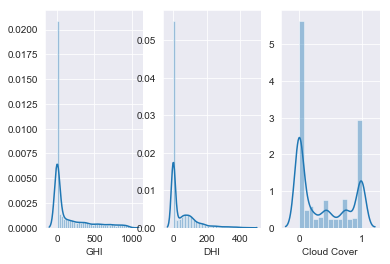

In [7]:
df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_south_dakota', 'psm_testing_data2018.csv'))
featureHistograms(df)

## II. Features and Data Engineering

So we have all the above variables....Which ones do we think would work best in a NN?

So we want to predict DHI, at the very least. Maybe DNI as well. What can we use to predict? 
[More Information on GHI, DHI, and DNI here!](https://firstgreenconsulting.wordpress.com/2012/04/26/differentiate-between-the-dni-dhi-and-ghi/#:~:text=Global%20Horizontal%20Irradiance%20(GHI)%20is,Diffuse%20Horizontal%20Irradiance%20(DHI).)

But a useful relationship to keep in mind is:

*Global Horizontal (GHI) = Direct Normal (DNI) X cos(θ) + Diffuse Horizontal (DHI)*

**GHI** is a must, as it is the primary metric our sensors will feed into such a model. 

**Cloud cover** is also essential, as cloud cover is one of the primary factors in how much direct normal solar irradience is diffused.

**Solar Zenith Angle** is important as it dictates how much irradience is direct normal (DNI)

Another useful relatinship to capture is **time**. We are given timestamps in addition to month, day, year, second, hour and minute variables. Timestamps and/or a combination between day + month would not be super useful, as it would overfit to the day. 
A more useful relationship would be to capture time of day. This is useful because in a non - featurized dataset, many GHI readings will read '0', simply because it is dark out. We are primarily concerned about the relationship between GHI and DHI, therefore factoring in readings when there is no sunlight to begin with could be confounding. Therefore adding in **minute** and **hour** variables in the input vector could adequately capture this relationship. 

Another solution would be to featurize this dataset, whereby we create a seperate feature which is a combination of day + time. OR, we could completly remove the nighttime entries entirely to ensure we only are concerned with readings that occur when the sun is out. However this occurs on a gradient, because sunlight is defracted even after sunset. So for now, let's just fit the model on the unedited dataset. 

Another good idea is to create a **season** variable, which is a dummy variable for each season (Fall, Winter, Spring, Summer), as different amounts of sunlight occur during each. The problem is that, for different locations on earth, seasonality could be inversely correlated with sunlight and thus GHI, DHI, and DNI. 

To keep the model as general as possible, we will exclude seasonality. 

Another useful metric is **Pressure**. According to the renowned [DISC model](https://www.nrel.gov/docs/legosti/old/3087.pdf), air pressure is included as a proxy for *air mass*, which is the amount of atmosphere solar rays have to travel through. The larger the solar mass, the more solar rays are scattered. 



### Loading the Data

Get training arrays and combine them into a useable vector

-Useful params:  
-Hours  
-Cloud Cover  
-GHI  
-Solar Zenith  
-Pressure  


Training Locations with Lat/Lon:  
-**Reliance, South Dakota** (43.85, -99.50) from 2010-2018  
-**Everglades, FL** (26.004157 ,-81.119239) from 2010-2018  
-**Spokane, WA** (47.41,-117.52) from 2010-2018  
-**Austin, TX** (30.581736,-98.024098) from 2010-2018  
-**Charlottesville, VA** (38.0086,-78.4532) from 2010-2018  

Please NOTE! In this notebook, the directory "Testing_Data" does not mean it is solely Testing Data. Rather for this Neural network, it contains both testing and training data. 
This is because the neural network requires much more data to train than regression. So much of the same data used to test the regression model is now being used to train the neural network. The True training data for the neural network is in "Proudction_Test", where the data is from USCRN and combined with data combed from darksky. 

In [13]:
def combine_training_arrays(df, input_arry, output_arr, dni_arr):
    ghi  = df['GHI'].values
    cloud_cover = df['Cloud Cover'].values
    hours = df['Hour'].values
    minutes = df['Minute'].values
    solar_zenith = df['Solar Zenith Angle'].values
    pressure = df['Pressure'].values
    dhi = df['DHI'].values
    dni = df['DNI'].values
    #Sanity check, should all be 8760
    assert len(pressure)==len(solar_zenith)==len(minutes)==len(hours)==len(cloud_cover)==len(ghi)==len(dni)==8760, "len of input array not 8760"
    ar = np.array([ghi, cloud_cover, hours, minutes, solar_zenith, pressure]).T
    input_arry = np.concatenate((input_arry, ar))
    output_arr = np.concatenate((output_arr, np.array(dhi).T))
    dni_arr = np.concatenate((dni_arr, np.array(dni).T))
    return input_arry, output_arr, dni_arr


In [16]:
# test_files = ['Murphey_ID', 'OldTown_ME', 'Quinault_WA', 'Lincoln_NE', 'SanDiego_CA', 'Boulder_CO', 'Miami_FL', 'outer_banks']
training_files = ['psm_south_dakota', 'Everglades_FL', 'Spokane_WA', 'Austin_TX', 'Charlottesville']
input_size = 6
input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
output_arry = np.array([], dtype=np.float64)
dni_arr = np.array([], dtype=np.float64)
print(input_arry)
print(output_arry)
print(dni_arr)
for directory in training_files:
    for file in glob(_Testing_Data_Dir+'/'+directory+'/psm_*'):
        df = pd.read_csv(file)
        input_arry, output_arry, dni_arr = combine_training_arrays(df, input_arry, output_arry, dni_arr)
print(len(input_arry), input_arry.shape)
print(len(output_arry), output_arry.shape)
print(len(dni_arr), dni_arr.shape)

[]
[]
[]
394200 (394200, 6)
394200 (394200,)
394200 (394200,)


In [17]:
#sanity check, make sure 8760*number of files we look at == 429240
count = 0
for path in glob(_Testing_Data_Dir+'/*'):
    for file in glob(path+'/psm_'+'*'):
        count+=1
print(count*8760)

630720


# III. Training

In [141]:
from tensorflow.keras.optimizers import Adam

In [142]:
keras.backend.clear_session()
tf.keras.backend.clear_session()

In [143]:
#Epoch size of 50 seems reasonable

In [144]:
keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph()>

In [145]:
keras.backend.clear_session()
tf.keras.backend.clear_session()

In [146]:
#make RMSE a custom metric

In [147]:
# def rmse(y_true, y_pred):
#     return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1))

In [148]:
model = keras.Sequential()
model.add(layers.Dense(300, activation="relu"))
model.add(layers.Dense(200, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(25, activation="relu"))
model.add(layers.Dense(1, activation='relu'))

In [ ]:
#Compile and train
model.compile(optimizer=Adam(lr=0.0001), 
              loss='mse',
              metrics=['mae',keras.metrics.RootMeanSquaredError()])

history = model.fit(input_arry, output_arry, epochs=100, batch_size=64)

Epoch 1/100
6160/6160 [==============================] - 11s 2ms/step - loss: 14195.6182 - mae: 65.8990 - root_mean_squared_error: 119.1454 0s - loss: 14204.4219 - mae: 65.8808 - root_me
Epoch 2/100
6160/6160 [==============================] - 13s 2ms/step - loss: 14195.6699 - mae: 65.8989 - root_mean_squared_error: 119.1456
Epoch 3/100
6160/6160 [==============================] - 14s 2ms/step - loss: 14195.5840 - mae: 65.8991 - root_mean_squared_error: 119.1452
Epoch 4/100
6160/6160 [==============================] - 16s 3ms/step - loss: 14195.6260 - mae: 65.8987 - root_mean_squared_error: 119.1454
Epoch 5/100
6160/6160 [==============================] - 13s 2ms/step - loss: 14195.6348 - mae: 65.8987 - root_mean_squared_error: 119.1454 0s - loss: 14177.8389 - mae: 65.8449 - roo
Epoch 6/100
6160/6160 [==============================] - 13s 2ms/step - loss: 14195.6309 - mae: 65.8989 - root_mean_squared_error: 119.1454
Epoch 7/100
6160/6160 [==============================] - 13s 2ms/step 

In [123]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 88,751
Trainable params: 88,751
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.7/site-packages/matplotlib-2.2.4-py3.7-macosx-10.15-x86_64.egg/matplotlib/legend.py:640: UserWarning: Unrecognized location "middle". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


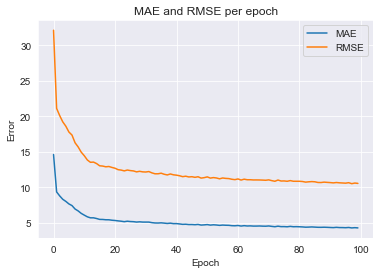

In [124]:
plt.plot(history.history['mae'])
plt.plot(history.history['root_mean_squared_error'])
plt.title('MAE and RMSE per epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['MAE', 'RMSE'], loc='middle')
plt.savefig('error-v-epoch.png')
plt.show()

In [48]:
#mae: 4.2719
#rmse 10.51

In [49]:
#MAE of around 4 w/m2. Considering DHI values go from 0 - 400, 4 represents a 1% error value

In [ ]:
# Prediction with DNI included


keras.backend.clear_session()
tf.keras.backend.clear_session()

keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph

keras.backend.clear_session()
tf.keras.backend.clear_session()

In [ ]:
model_dni = keras.Sequential()
model_dni.add(layers.Dense(300, activation="relu"))
model_dni.add(layers.Dense(200, activation="relu"))
model_dni.add(layers.Dense(100, activation="relu"))
model_dni.add(layers.Dense(50, activation="relu"))
model_dni.add(layers.Dense(25, activation="relu"))
model_dni.add(layers.Dense(1, activation='relu'))

In [ ]:
#Compile and train
model_dni.compile(optimizer=Adam(lr=0.0001), 
              loss='mse',
              metrics=['mae',keras.metrics.RootMeanSquaredError()])

history_dni = model.fit(input_arry, dni_arr, epochs=100, batch_size=64)

## IV. Model Validation - Outer Banks

In [50]:
validation_df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'outer_banks', 'r_banks.csv'))
validation_df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,timestamps,Cloud Cover
0,2018,1,1,0,30,1.8,0,0,0,4,...,0,85.84,119.89,0.03,1026,1.2,350,8.6,1514782800,1.00
1,2018,1,1,1,30,1.6,0,0,0,4,...,0,87.76,132.05,0.03,1026,1.2,348,8.7,1514786400,0.94
2,2018,1,1,2,30,1.5,0,0,0,4,...,0,88.35,144.19,0.03,1026,1.1,346,8.7,1514790000,1.00
3,2018,1,1,3,30,1.4,0,0,0,4,...,0,89.16,155.85,0.03,1026,1.1,346,8.7,1514793600,1.00
4,2018,1,1,4,30,1.4,0,0,0,4,...,0,89.52,165.32,0.03,1026,1.1,347,8.9,1514797200,1.00


In [52]:
input_size = 6
val_input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
val_output_arry = np.array([], dtype=np.float64)
val_dni_arr = np.array([], dtype=np.float64)
val_input_arry, val_output_arry, val_dni_arr = combine_training_arrays(validation_df, val_input_arry, val_output_arry, val_dni_arr)

In [53]:
#keras model.evaluate reveals a mae of 6.9433 w/m2 in the outer banks test

In [126]:
score = model.evaluate(val_input_arry, [val_output_arry, val_dni_arr], verbose=1)

274/274 [==============================] - 1s 2ms/step - loss: 262.3155 - mae: 6.6264 - root_mean_squared_error: 16.1962


In [136]:
preds = model.predict(val_input_arry)


[[ 0.      ]
 [ 0.      ]
 [ 0.      ]
 ...
 [13.171021]
 [ 0.      ]
 [ 0.      ]]


In [137]:
#Mape too high because of 0 values

In [138]:
#Compare random induvidual resutls!!!!!

In [140]:
i = randint(0,8760)
print("index is ",i)
print("Actual ",val_output_arry[i]," ","Predicted ", preds[i])

index is  7623
Actual  138.0   Predicted  [138.84602]


In [96]:
# Now lets see how it fares for DNI


[ 0.  0.  0. ... 14.  0.  0.]
[[0.0000e+00 1.0000e+00 0.0000e+00 3.0000e+01 1.1989e+02 1.0260e+03]
 [0.0000e+00 9.4000e-01 1.0000e+00 3.0000e+01 1.3205e+02 1.0260e+03]
 [0.0000e+00 1.0000e+00 2.0000e+00 3.0000e+01 1.4419e+02 1.0260e+03]
 ...
 [1.4000e+01 8.3000e-01 2.1000e+01 3.0000e+01 8.5590e+01 1.0220e+03]
 [0.0000e+00 9.9000e-01 2.2000e+01 3.0000e+01 9.6530e+01 1.0220e+03]
 [0.0000e+00 8.4000e-01 2.3000e+01 3.0000e+01 1.0800e+02 1.0220e+03]]


In [103]:
def predict_dni(ghi, dhi, solar_zenith):
    dni = []
    for i in range(len(ghi)):
        diff = float(ghi[i])-float(dhi[i])
        cos_sol_A = create_cos_sol_A(float(solar_zenith[i]))
        dni.append(diff/cos_sol_A)
    return dni
    

In [105]:
solar_zenith =(validation_df['Solar Zenith Angle'])
dni_vector = predict_dni(val_input_arry[:,0], preds, solar_zenith)
print(dni_vector)
print(len(dni_vector))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1475246869957619, 3.9245702621100462, 445.6219908305781, 61.83662226757232, 21.204874530933356, 40.54945815222651, 10.817851659467554, 24.331143077772936, -1.0944797121404304, 0.6104941819941831, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.388158712818707, -0.2038262513331601, 757.0155843380431, 829.3558151644696, 324.5557994377664, 259.75532341718935, 195.54836940913134, 148.24014785620892, 116.50421543391884, 5.016636731746267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6754655439465596, 29.173285283112275, 183.5698515489402, 324.8838715999517, 346.00254691465784, 216.3749080000053, 196.88630697626854, 40.056120100083646, -6.3525445325597305, -0.11306752133663456, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5655130673357633, -0.06481658771816683, -3.5603677349938523, 12.998962626941392, 229.98412128147967, 151.7837811664955, 113.83688960

In [111]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [112]:
mae = mean_absolute_error(val_dni_arr, dni_vector)
rmse = sqrt(mean_squared_error(val_dni_arr, dni_vector))
print(mae)
print(rmse)

424.1438270914033
6694.271971700816


In [113]:
# Mathematical method of DNI deriviation is way off

In [75]:
# model.save('Neural_Net_National')

INFO:tensorflow:Assets written to: Neural_Net_National/assets


## V. Model Testing - Other Locations

Lets take the global model and test in new locations. Lets test on the following locations for the year 2018.


1. Outer Banks (35.5585, -75.4665)
2. Miami Florida (25.7617, -80.1918)
3. Boulder CO (40.035,-105.54)
4. San Diego CA (32.7157, -117.1611)
5. Lincoln Nebraska (40.848,-96.56)
6. Quinault Washington (47.513,-123.81)
7. Old Town Maine (44.928,-68.70)
8. Murphey Idaho (43.204,-116.75)


In [76]:
#Test General model

In [77]:
National_model = keras.models.load_model('Neural_Nets/Neural_Net_National')

In [78]:
National_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2100      
_________________________________________________________________
dense_1 (Dense)              multiple                  60200     
_________________________________________________________________
dense_2 (Dense)              multiple                  20100     
_________________________________________________________________
dense_3 (Dense)              multiple                  5050      
_________________________________________________________________
dense_4 (Dense)              multiple                  1275      
_________________________________________________________________
dense_5 (Dense)              multiple                  26        
Total params: 88,751
Trainable params: 88,751
Non-trainable params: 0
____________________________________________________

In [94]:
test_files = ['Murphey_ID', 'OldTown_ME', 'Quinault_WA', 'Lincoln_NE', 'SanDiego_CA', 'Boulder_CO', 'Miami_FL', 'outer_banks']
scores = {}
for directory in test_files:
    for file in glob(_Testing_Data_Dir+'/'+directory+'/psm_*2018.csv'):
        test_df = pd.read_csv(str(file))
        input_size = 6
        test_input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
        test_output_arry = np.array([], dtype=np.float64)
        test_input_arry, test_output_arry = combine_training_arrays(test_df, test_input_arry, test_output_arry)
        print(file)
        score = National_model.evaluate(test_input_arry, test_output_arry, verbose=1)
        scores[directory] = score


/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Murphey_ID/psm_ID_Murphey2018.csv
274/274 [==============================] - 0s 984us/step - loss: 256.5927 - mean_absolute_error: 6.7838 - root_mean_squared_error: 16.0185
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/OldTown_ME/psm_ME_OldTown2018.csv
274/274 [==============================] - 0s 932us/step - loss: 229.4214 - mean_absolute_error: 6.8104 - root_mean_squared_error: 15.1467
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Quinault_WA/psm_WA_Quinault2018.csv
274/274 [==============================] - 0s 1ms/step - loss: 104.5538 - mean_absolute_error: 4.2643 - root_mean_squared_error: 10.2252
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Lincoln_NE/psm_NE_Lincoln2018.csv
274/274 [==============================] - 0s 1ms/step - loss: 161.9369 - mean_absolute

In [95]:
scores.items()

dict_items([('Murphey_ID', [256.5926818847656, 6.783843994140625, 16.018510818481445]), ('OldTown_ME', [229.42138671875, 6.810364246368408, 15.146662712097168]), ('Quinault_WA', [104.5538101196289, 4.2642903327941895, 10.2251558303833]), ('Lincoln_NE', [161.93692016601562, 5.263095855712891, 12.725443840026855]), ('SanDiego_CA', [289.1909484863281, 7.785069942474365, 17.005615234375]), ('Boulder_CO', [1862.31884765625, 16.543825149536133, 43.15459060668945]), ('Miami_FL', [675.23779296875, 10.51191234588623, 25.98533821105957])])

In [96]:
#Only Miami and Boulder_CO seem to be outliers

## V.I Model Testing, Boulder Specific

Lets see if we can train a model specific for Boulder, CO and see if we can get the mae down.
Let's fetch more data from NRSDB and combine it with our readings from Darksky. Lets get data from 2008-2018.

In [103]:
input_size = 6
input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
output_arry = np.array([], dtype=np.float64)
print(input_arry)
print(output_arry)
from glob import glob
for path in glob(_Testing_Data_Dir+'/Boulder_CO'):
    for file in glob(path+'/psm_'+'*'):
        print(file)
        df = pd.read_csv(file)
        input_arry, output_arry = combine_training_arrays(df, input_arry, output_arry)

[]
[]
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2018.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2008.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2009.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2010.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2011.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2013.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2012.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Boulder_CO/psm_CO_Boulder2016.csv
/U

In [104]:
keras.backend.clear_session()
tf.keras.backend.clear_session()

In [105]:
keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph()>

In [106]:
model_Boulder = keras.Sequential()
model_Boulder.add(keras.layers.Dense(300, activation="relu"))
model_Boulder.add(layers.Dense(200, activation="relu"))
model_Boulder.add(layers.Dense(100, activation="relu"))
model_Boulder.add(layers.Dense(50, activation="relu"))
model_Boulder.add(layers.Dense(25, activation="relu"))
model_Boulder.add(layers.Dense(1, activation='relu'))

In [107]:
#Compile and train
model_Boulder.compile(optimizer=Adam(lr=0.0001), 
              loss='mse',
              metrics=['mae',keras.metrics.RootMeanSquaredError()])

history_Boulder = model_Boulder.fit(input_arry, output_arry, epochs=100, batch_size=32)

Epoch 1/100
3012/3012 [==============================] - 5s 1ms/step - loss: 3136.6509 - mae: 27.1907 - root_mean_squared_error: 56.0058
Epoch 2/100
3012/3012 [==============================] - 5s 2ms/step - loss: 669.0169 - mae: 10.9336 - root_mean_squared_error: 25.8654
Epoch 3/100
3012/3012 [==============================] - 5s 2ms/step - loss: 583.5402 - mae: 9.9415 - root_mean_squared_error: 24.1566
Epoch 4/100
3012/3012 [==============================] - 6s 2ms/step - loss: 572.9196 - mae: 9.7745 - root_mean_squared_error: 23.9357
Epoch 5/100
3012/3012 [==============================] - 6s 2ms/step - loss: 565.0255 - mae: 9.5376 - root_mean_squared_error: 23.7703
Epoch 6/100
3012/3012 [==============================] - 5s 2ms/step - loss: 545.2877 - mae: 9.3087 - root_mean_squared_error: 23.3514: 2s - loss: 516.5451 - mae: 9.0326 - root_mean_sq
Epoch 7/100
3012/3012 [==============================] - 6s 2ms/step - loss: 524.0295 - mae: 9.0873 - root_mean_squared_error: 22.8917
Ep

In [70]:
#MAE falls to around 6.99

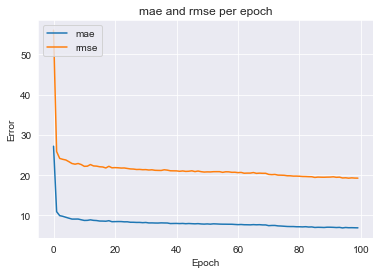

In [115]:
plt.plot(history_Boulder.history['mae'])
plt.plot(history_Boulder.history['root_mean_squared_error'])
plt.title('mae and rmse per epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['mae', 'rmse'], loc='upper left')
plt.show()

## V.II Model Testing,  Boulder Specific Model on Boulder 2018 data

Test on 2018 data only

In [116]:
test_df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'Boulder_CO', 'psm_CO_Boulder2018.csv'))
test_df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (285-385nm),timestamps,Cloud Cover
0,2018,1,1,0,30,-14.3,0,0,0,0,...,98.21,0.67,711,0.2,261,0.9,NaN,NaN,1514782800,0.00
1,2018,1,1,1,30,-15.6,0,0,0,0,...,109.06,0.67,711,0.2,254,1.2,NaN,NaN,1514786400,0.00
2,2018,1,1,2,30,-16.3,0,0,0,0,...,120.35,0.67,711,0.1,252,1.1,NaN,NaN,1514790000,0.64
3,2018,1,1,3,30,-16.7,0,0,0,0,...,131.81,0.67,711,0.1,256,1.0,NaN,NaN,1514793600,0.64
4,2018,1,1,4,30,-17.0,0,0,0,0,...,143.11,0.67,711,0.1,261,1.0,NaN,NaN,1514797200,0.64


In [117]:
input_size = 6
test_input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
test_output_arry = np.array([], dtype=np.float64)
test_input_arry, test_output_arry = combine_training_arrays(test_df, test_input_arry, test_output_arry)

In [118]:
score = model_Boulder.evaluate(test_input_arry, test_output_arry, verbose=1)

274/274 [==============================] - 0s 956us/step - loss: 978.8859 - mae: 12.8149 - root_mean_squared_error: 31.2872


In [119]:
#12.8149 is better than 15

## V.III Model Testing Miami Specific
Lets train on NRSDB + Darksky data from 08-18

In [120]:
input_size = 6
input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
output_arry = np.array([], dtype=np.float64)
print(input_arry)
print(output_arry)
from glob import glob
for path in glob(_Testing_Data_Dir+'/Miami_FL'):
    for file in glob(path+'/psm_'+'*'):
        print(file)
        df = pd.read_csv(file)
        input_arry, output_arry = combine_training_arrays(df, input_arry, output_arry)

[]
[]
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2009.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2008.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2018.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2017.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2016.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2014.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2015.csv
/Users/tuomastalvitie/Documents/GRIP/Diffuse:Direct/solarIrradiencePredictor/Testing_Data/Miami_FL/psm_FL_Miami2011.csv
/Users/tuomastalvitie/Documents/GR

In [122]:
keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph()>

In [123]:
model_Miami = keras.Sequential()
model_Miami.add(keras.layers.Dense(300, activation="relu"))
model_Miami.add(layers.Dense(200, activation="relu"))
model_Miami.add(layers.Dense(100, activation="relu"))
model_Miami.add(layers.Dense(50, activation="relu"))
model_Miami.add(layers.Dense(25, activation="relu"))
model_Miami.add(layers.Dense(1, activation='relu'))

In [124]:
#Compile and train
model_Miami.compile(optimizer=Adam(lr=0.0001), 
              loss='mse',
              metrics=['mae', keras.metrics.RootMeanSquaredError()])

history_Miami = model_Miami.fit(input_arry, output_arry, epochs=100, batch_size=64)

Epoch 1/100
1506/1506 [==============================] - 3s 2ms/step - loss: 2633.1914 - mae: 26.4663 - root_mean_squared_error: 51.3146
Epoch 2/100
1506/1506 [==============================] - 3s 2ms/step - loss: 296.6196 - mae: 8.2286 - root_mean_squared_error: 17.2226
Epoch 3/100
1506/1506 [==============================] - 3s 2ms/step - loss: 242.9046 - mae: 7.1133 - root_mean_squared_error: 15.5854
Epoch 4/100
1506/1506 [==============================] - 3s 2ms/step - loss: 223.9117 - mae: 6.7212 - root_mean_squared_error: 14.9637: 0s - loss: 221.0543 - mae: 6.6691 - root_mean_squared_error: 1
Epoch 5/100
1506/1506 [==============================] - 3s 2ms/step - loss: 214.0983 - mae: 6.5390 - root_mean_squared_error: 14.6321
Epoch 6/100
1506/1506 [==============================] - 3s 2ms/step - loss: 208.1112 - mae: 6.3846 - root_mean_squared_error: 14.4261
Epoch 7/100
1506/1506 [==============================] - 3s 2ms/step - loss: 205.5375 - mae: 6.3092 - root_mean_squared_erro

In [125]:
#Mae down to 5.4439

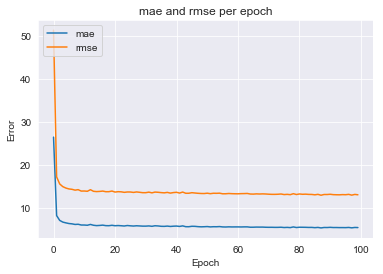

In [126]:
plt.plot(history_Miami.history['mae'])
plt.plot(history_Miami.history['root_mean_squared_error'])
plt.title('mae and rmse per epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['mae', 'rmse'], loc='upper left')
plt.show()

Test on Miami 2018 data

In [127]:
test_df = pd.read_csv(os.path.join(_Testing_Data_Dir, 'Miami_FL', 'psm_FL_Miami2018.csv'))
test_df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (285-385nm),timestamps,Cloud Cover
0,2018,1,1,0,30,21.1,0,0,0,0,...,113.89,0.08,1019,2.7,58,2.0,NaN,NaN,1514782800,0.30
1,2018,1,1,1,30,21.2,0,0,0,0,...,127.06,0.08,1019,2.8,63,1.8,NaN,NaN,1514786400,0.32
2,2018,1,1,2,30,21.2,0,0,0,0,...,140.43,0.08,1019,2.8,65,1.6,NaN,NaN,1514790000,0.23
3,2018,1,1,3,30,21.2,0,0,0,0,...,153.91,0.08,1018,2.9,57,1.3,NaN,NaN,1514793600,0.14
4,2018,1,1,4,30,21.1,0,0,0,0,...,167.37,0.08,1018,2.9,41,1.1,NaN,NaN,1514797200,0.14


In [128]:
input_size = 6
test_input_arry = np.array([], dtype=np.float64).reshape(0,input_size)
test_output_arry = np.array([], dtype=np.float64)
test_input_arry, test_output_arry = combine_training_arrays(test_df, test_input_arry, test_output_arry)

In [129]:
score = model_Miami.evaluate(test_input_arry, test_output_arry, verbose=1)

274/274 [==============================] - 0s 957us/step - loss: 639.4745 - mae: 10.1002 - root_mean_squared_error: 25.2878


In [21]:
#Mae of 10.1002....not bad!~

In [130]:
#Save models

In [132]:
model_Boulder.save('Neural_Nets/Neural_Net_Boulder_CO')

INFO:tensorflow:Assets written to: Neural_Nets/Neural_Net_Boulder_CO/assets


In [133]:
model_Miami.save('Neural_Nets/Neural_Net_Miami_FL')

INFO:tensorflow:Assets written to: Neural_Nets/Neural_Net_Miami_FL/assets
